# Modeling

This notebook uses a wide variety of modeling algorithms for a binary classification problem. It reads a file created from a feature selection process that has a reasonably small number of good variables, and we know their order of multivariate importance because we used a proper wrapper method. We can explore # input variables, model algorithms and tune model hyperparameters. At the end we can select our favorite algorithm, run it again and build the final model performace score percentile tables.

Here we call the larger fraction population the goods and the smaller fraction the bads. This notebook was originally
written for fraud detection but can be used for any binary classification. It uses detection rate as an appropriate measure of goodness.

Rather than use a built-in CV, we do a "manual CV" by running each model multiple (nitermax) times and average the performance on the training (trn), testing (tst) and out of time (oot) data sets.

Some of the ML algorithms are very fast and some are slow. Feel free to comment out any cells/models you want. At the bottom of the notebook you can select your final model/hyperparameters to run one time only and then make the business perfoemance tables for that final model.

Things to add: better calculation of FDR@3% when building a model using sampled training data. Right now I just approximate it by using the entire population trntst for a model built with sampled data.

In [2]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from datetime import datetime
start_time = datetime.now()

import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
%%time
vars = pd.read_csv('/content/sample_data/vars_final.csv')
print(vars.shape)
vars.head()

(1000000, 22)
CPU times: user 3.02 s, sys: 1.06 s, total: 4.08 s
Wall time: 9.24 s


,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,...,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60,address_unique_count_for_ssn_name_dob_60,address_unique_count_for_dob_homephone_60,address_unique_count_for_ssn_homephone_60,address_unique_count_for_ssn_lastname_60,address_unique_count_for_ssn_60,record,fraud_label
0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0
2,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,0.0
3,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,0.0
4,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,0.0


In [5]:
# set the number of variables desired here, and set the names of the y and record number properly
NVARS = 15

vars.rename(columns={'record':'Recnum'},inplace=True)
vars.rename(columns={'fraud_label':'Fraud'},inplace=True)
numvars = min(NVARS,len(vars)-2)
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'fulladdress_day_since',
 'name_dob_count_30',
 'address_unique_count_for_name_homephone_60',
 'fulladdress_unique_count_for_dob_homephone_3',
 'address_unique_count_for_homephone_name_dob_30',
 'address_unique_count_for_ssn_name_dob_14',
 'address_day_since',
 'address_count_14',
 'address_count_7',
 'address_count_0_by_30',
 'address_unique_count_for_homephone_name_dob_60',
 'fulladdress_count_0_by_30',
 'address_unique_count_for_ssn_zip5_60',
 'address_unique_count_for_ssn_name_60',
 'address_unique_count_for_ssn_firstname_60']

In [6]:
vars = vars.filter(final_vars_list,axis=1)
vars.head()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0


In [7]:
vars.shape

(1000000, 17)

In [8]:
vars['Fraud'].sum()

14393.0

In [9]:
vars.head(10)

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
0,1.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
1,2.0,1.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
2,3.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
3,4.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
4,5.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
5,6.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
6,7.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
7,8.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
8,9.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0
9,10.0,0.0,365.0,1.0,1.0,1.0,1.0,1.0,365.0,1.0,1.0,30.0,1.0,30.0,1.0,1.0,1.0


In [10]:
vars.shape

(1000000, 17)

In [11]:
vars.describe()

,Recnum,Fraud,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,0.014393,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754,1.063893,1.063768
std,288675.278932,0.119104,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405,0.699542,0.699434
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000,1.000000,1.000000
25%,250000.750000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
50%,500000.500000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
75%,750000.250000,0.000000,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
max,1000000.000000,1.000000,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [12]:
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0


## Scale and truncate field values

In [13]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,325.060480,1.046384,1.066381,1.028348,1.052878,1.042172,320.117207,1.054768,1.042577,29.358254,1.069813,29.489603,1.063754,1.063893,1.063768
std,99.097485,0.497036,0.701078,0.539675,0.641431,0.607350,104.836655,0.618082,0.585789,3.205310,0.703726,2.834776,0.699405,0.699542,0.699434
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.304348,1.000000,1.304348,1.000000,1.000000,1.000000
25%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
50%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
75%,365.000000,1.000000,1.000000,1.000000,1.000000,1.000000,365.000000,1.000000,1.000000,30.000000,1.000000,30.000000,1.000000,1.000000,1.000000
max,365.000000,34.000000,30.000000,30.000000,30.000000,30.000000,365.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000


In [14]:
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [16]:
# use this to cap variables. For some problems it helps
Clip = 10

In [17]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True)
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06
mean,1.903970e-16,7.138112e-17,-3.879563e-17,-5.170264e-17,2.567901e-17,-1.343388e-16,-3.440448e-17,1.012914e-16,-1.513563e-16,-1.992159e-15,1.536975e-16,3.791345e-15,-1.396501e-16,6.403411e-17,-8.203926e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.280209e+00,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,-3.053486e+00,-8.860966e-02,-7.268319e-02,-8.752323e+00,-9.920487e-02,-9.942674e+00,-9.115457e-02,-9.133546e-02,-9.117084e-02
25%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02
50%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02
75%,4.030326e-01,-9.332121e-02,-9.468412e-02,-5.252795e-02,-8.243749e-02,-6.943609e-02,4.281212e-01,-8.860966e-02,-7.268319e-02,2.002135e-01,-9.920487e-02,1.800485e-01,-9.115457e-02,-9.133546e-02,-9.117084e-02
max,4.030326e-01,6.630026e+01,4.127016e+01,5.368356e+01,4.512894e+01,4.767899e+01,4.281212e-01,4.683076e+01,4.943321e+01,2.002135e-01,4.111004e+01,1.800485e-01,4.137264e+01,4.136435e+01,4.137092e+01


In [18]:
# separate data into modeling (traintest) and out of time. Here I'm using the record number to do this separation.
# you need to change this oot record number to whatever is appropriate for your data
oot_recnum=833507
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [19]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [20]:
alphas = 10**np.linspace(2,9,30)*0.5

In [21]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [22]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 15)

CPU times: user 999 ms, sys: 19.8 ms, total: 1.02 s
Wall time: 1.5 s


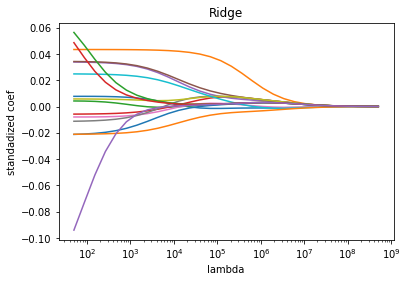

In [23]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [24]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [25]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.114e+02, tolerance: 8.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.211e+02, tolerance: 8.267e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e+01, tolerance: 8.267e-01

Selected Features: []
CPU times: user 27min 49s, sys: 1min 44s, total: 29min 33s
Wall time: 17min 35s


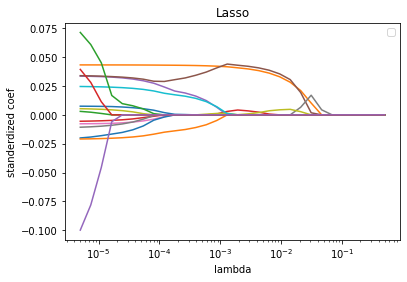

In [26]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
plt.legend()
plt.savefig('lasso.png')

## Look at PCA

In [27]:
len(X_trntst.columns)

15

In [28]:
X_trntst_save = X_trntst.copy()

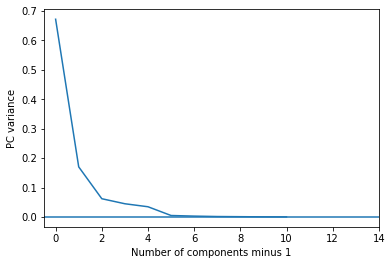

In [29]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [30]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
1,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
2,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
3,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
4,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323


In [31]:
princ_comps = pca.transform(X_oot)
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
833507,0.102589,-1.833759,-1.524099,1.514492,0.119382,0.018427
833508,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
833509,2.445230,-7.745104,1.124075,-1.534624,-1.067696,0.015400
833510,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
833511,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323


In [32]:
X_trntst.describe()

,fulladdress_day_since,name_dob_count_30,address_unique_count_for_name_homephone_60,fulladdress_unique_count_for_dob_homephone_3,address_unique_count_for_homephone_name_dob_30,address_unique_count_for_ssn_name_dob_14,address_day_since,address_count_14,address_count_7,address_count_0_by_30,address_unique_count_for_homephone_name_dob_60,fulladdress_count_0_by_30,address_unique_count_for_ssn_zip5_60,address_unique_count_for_ssn_name_60,address_unique_count_for_ssn_firstname_60
count,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000,833507.000000
mean,0.031522,-0.001708,-0.000377,0.001320,0.000348,0.000852,0.031615,0.000682,0.001052,0.000987,-0.000473,0.000686,-0.000253,-0.000254,-0.000254
std,0.981263,0.979550,0.996756,1.013675,1.002736,1.008244,0.983233,1.007653,1.011013,0.997512,0.996709,0.998151,0.997370,0.997336,0.997358
min,-3.280209,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,-3.053486,-0.088610,-0.072683,-8.752323,-0.099205,-9.942674,-0.091155,-0.091335,-0.091171
25%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171
50%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171
75%,0.403033,-0.093321,-0.094684,-0.052528,-0.082437,-0.069436,0.428121,-0.088610,-0.072683,0.200213,-0.099205,0.180049,-0.091155,-0.091335,-0.091171
max,0.403033,66.300262,41.270156,53.683556,45.128940,47.678988,0.428121,46.830762,49.433212,0.200213,41.110043,0.180049,41.372637,41.364353,41.370917


In [33]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.037308,-0.195574,-0.122984,0.129292,0.026586,-0.000176
std,3.089476,1.654419,1.102289,0.921288,0.803074,0.310022
min,-0.398339,-17.945408,-3.347276,-7.386734,-11.108624,-4.181878
25%,-0.398339,-0.196839,0.052509,-0.138054,-0.047243,0.012323
50%,-0.398339,0.500547,0.127912,-0.138054,-0.047243,0.012323
75%,-0.238553,0.500547,0.127912,-0.138054,-0.041712,0.012323
max,138.123706,31.522204,47.058135,26.698606,38.975530,14.879055


In [34]:
# zscale the PCs
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [35]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05,8.335070e+05
mean,8.729330e-18,2.073216e-17,-5.865019e-18,2.755195e-17,-2.804638e-18,2.719391e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.257343e-01,-1.366360e+01,-3.848354e+00,-1.047926e+01,-1.501337e+01,-1.780839e+01
25%,-1.257343e-01,3.135366e-01,1.324184e-01,-1.677122e-01,-6.517187e-02,4.309251e-02
50%,-1.257343e-01,3.135366e-01,1.324184e-01,-1.677122e-01,-6.517187e-02,4.309251e-02
75%,-1.257343e-01,3.135366e-01,1.324184e-01,-1.677122e-01,-6.517187e-02,4.309251e-02
max,4.349889e+01,2.029418e+01,5.739172e+01,3.825600e+01,5.763931e+01,5.840012e+01


In [36]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000,166493.000000
mean,0.011776,-0.122505,-0.127317,0.157068,0.036676,-0.000614
std,0.975182,1.036308,1.141125,1.119207,1.107843,1.084165
min,-0.125734,-11.240781,-3.465206,-8.973613,-15.324384,-14.624252
25%,-0.125734,-0.123297,0.054359,-0.167712,-0.065172,0.043093
50%,-0.125734,0.313537,0.132418,-0.167712,-0.065172,0.043093
75%,-0.075298,0.313537,0.132418,-0.167712,-0.057542,0.043093
max,43.598250,19.745118,48.716072,32.434222,53.766874,52.032860


In [37]:
X_trntst_pca.shape

(833507, 6)

In [38]:
X_oot_orig_pca.shape

(166493, 6)

## Subsample the larger class if desired

In [39]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True)
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect()
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.0144053979150745
(23841, 15) 23841


In [40]:
niter = 0
nitermax = 5
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

You can comment in/out any of these model cells and just explore one model type. You can also just rerun that single cell multiple times (hit shift-enter on that cell) as you manually explore different model hyperparameters.

In [41]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [111]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=20, solver = 'liblinear', l1_ratio = 0.4)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0 0.4769615430408382 0.47838137472283815 0.4639564124056999


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


1 0.4707924347617908 0.49219819326580894 0.4631181894383906


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


2 0.47040572792362767 0.4921422663358147 0.4631181894383906


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


3 0.4747462827472268 0.4825926974242853 0.4631181894383906


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


4 0.48829787234042554 0.48632647307583876 0.4744341994970662
trn    0.476241
tst    0.486328
oot    0.465549
dtype: float64
CPU times: user 9.08 s, sys: 1.27 s, total: 10.4 s
Wall time: 10.1 s


In [112]:
%%time
# Single DT

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(max_depth=30,min_samples_split= 10,min_samples_leaf=3)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.5320284697508897 0.5247414034106793 0.5008382229673093
1 0.5331818725337798 0.5197585071350165 0.5008382229673093
2 0.5351979141976771 0.5130288596245447 0.49874266554903607
3 0.5331422429236833 0.5165107319757842 0.4966471081307628
4 0.5298823529411765 0.5263758197889934 0.5016764459346186
trn    0.532687
tst    0.520083
oot    0.499749
dtype: float64
CPU times: user 4.94 s, sys: 15 ms, total: 4.95 s
Wall time: 5.04 s


In [42]:
%%time
# RF

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(n_estimators=100,max_depth=30,min_samples_split=20,min_samples_leaf=5,max_features=10)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5428198123292552 0.520345596432553 0.5020955574182733
1 0.5467753366406803 0.5097430104490257 0.5033528918692373
2 0.5423468180742843 0.5184351252462708 0.4991617770326907
3 0.5454975742515679 0.514341957255343 0.49832355406538137
4 0.542498505678422 0.5219659527732016 0.5004191114836547
trn    0.543988
tst    0.516966
oot    0.500671
dtype: float64
CPU times: user 5min, sys: 811 ms, total: 5min 1s
Wall time: 5min 6s


In [43]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(n_estimators=1000, max_depth = 6, num_leaves=10, col_sample_bytree = 0.8, learning_rate = 0.01, eval_metric = 'logloss')

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5250864020974854 0.5320796460176991 0.501257334450964
1 0.5324799617179088 0.5167214912280702 0.5025146689019279
2 0.532844123564919 0.5154581225407532 0.5071248952221291
3 0.5318023325718408 0.5178861788617887 0.5071248952221291
4 0.533373063170441 0.5158971523361903 0.5054484492875104
trn    0.531117
tst    0.519609
oot    0.504694
dtype: float64
CPU times: user 12min 2s, sys: 1.95 s, total: 12min 4s
Wall time: 7min 13s


In [43]:
%%time
# NN

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(20),activation = 'relu', alpha = 0.0001, learning_rate = 'adaptive', solver = 'lbfgs', learning_rate_init = 0.0001 )

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.522967772967773 0.5367109184502845 0.5075440067057837
1 0.5240648081963307 0.5341821201217825 0.5071248952221291
2 0.5221450802011013 0.5359978100191624 0.5067057837384744
3 0.5306752106324908 0.5175977653631285 0.5067057837384744
4 0.5282368327190584 0.525027808676307 0.509639564124057
trn    0.525618
tst    0.529903
oot    0.507544
dtype: float64
CPU times: user 5min 17s, sys: 2min 39s, total: 7min 57s
Wall time: 4min 53s


In [ ]:
%%time
# NN on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(2))

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [113]:
%%time
# GBC

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth=15,n_estimators=100, min_samples_leaf = 5, subsample = 0.5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5296852646638054 0.5283227410886986 0.5020955574182733
1 0.5340184266477676 0.5162383507483762 0.501257334450964
2 0.5347989654361627 0.5172807769208797 0.49874266554903607
3 0.5359002300520644 0.5109391675560299 0.5008382229673093
4 0.5362753327737139 0.514721919302072 0.5004191114836547
trn    0.534136
tst    0.517501
oot    0.500671
dtype: float64
CPU times: user 4min 29s, sys: 403 ms, total: 4min 30s
Wall time: 4min 32s


In [42]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(bootstrap_type = 'MVS', verbose=0, max_depth=16, iterations=20, random_state=5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.5305585456285133 0.5252331321996708 0.5046102263202011
1 0.5300107823170002 0.5259562841530054 0.5062866722548198
2 0.5310155970948922 0.5252217294900222 0.5037720033528919
3 0.5304995196926032 0.524870888828486 0.5037720033528919
4 0.5339307048984469 0.5188342040142975 0.5062866722548198
trn    0.531203
tst    0.524023
oot    0.504946
dtype: float64
CPU times: user 4min 47s, sys: 1min 4s, total: 5min 51s
Wall time: 4min 2s


In [ ]:
%%time
# NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# Only use this cell if you do downsampling of the goods.
# each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
print(xmult)
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

    model.fit(X_trn, Y_trn.values.ravel())  
    
    X_oot = X_oot_orig.copy()
    X_trn = X_trntst.copy()
    Y_trn = Y_trntst.copy()
    X_tst = X_trntst.copy()
    Y_tst = Y_trntst.copy()


    predictions = model.predict_proba(X_trntst)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_trntst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_trntst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
%%time
# Catboost on pc's

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
%%time
# unsupervised model using pc's. 

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

    X_oot = X_oot_orig_pca.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    pow = 2
    oop = 1/pow
    predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

In [44]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=20, n_estimators=100, tree_method= 'auto', subsample = 0.5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.541337421865786 0.5195578231292517 0.5
1 0.5393766357363787 0.5201332963065814 0.49874266554903607
2 0.5429415239220319 0.5146809712027103 0.501257334450964
3 0.5380545869905013 0.5246612466124662 0.4974853310980721
4 0.5373781148429035 0.5278378378378379 0.5016764459346186
trn    0.539818
tst    0.521374
oot    0.499832
dtype: float64
CPU times: user 15min 20s, sys: 2.67 s, total: 15min 23s
Wall time: 15min 29s


In [ ]:
# %%time
# # Knn
# # Knn can be very slow with a lot of records.

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [ ]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [ ]:
df = Modeling_output.dropna()
df.head(20)

In [ ]:
df.shape

In [ ]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

In [ ]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

In [ ]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])

plt.ylim(.5,.7)
plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')
plt.show()

In [ ]:
print('duration: ', datetime.now() - start_time)

The rest of the notebook makes the tables for your final model of choice. You need to run that final model only once (no CV). If you want you can run the below cell over and over by itself until it gives you a model you like (due to the stochastic nature of some ML algorithms, but you can't change from your best hyperparameters.

In [ ]:
%%time

for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = CatBoostClassifier(verbose=0, iterations=100)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

In [ ]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [ ]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

In [ ]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

In [ ]:
FDR3.to_csv('FDR3.csv')

In [ ]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [ ]:
print("duration: ", datetime.now() - start_time)